### Load libraries

In [18]:
library(plyr)
library(tidyverse)
library(stringr)
library(phyloseq)
library(microViz)
library(metagMisc)
library(ggplot2)
library(ggsci)
library(viridis)
library(conflicted)
library(gridExtra)
library(vegan)
library(ape)
library(lattice)
library(permute)
library(grid) 
library(knitr)
library(cowplot)
library(pwr)
library(GMSE)

ERROR: Error: package or namespace load failed for ‘tidyverse’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace ‘cli’ 3.4.1 is already loaded, but >= 3.6.1 is required


### Declare conflict preferences

In [17]:
conflict_prefer("filter","dplyr")
conflict_prefer("rename","dplyr")
conflict_prefer("mutate","dplyr")
conflict_prefer("count","dplyr")

ERROR: Error in conflict_prefer("filter", "dplyr"): could not find function "conflict_prefer"


## Power analysis

In [223]:
# Set the desired significance level (alpha) and power level
alpha <- 0.05
power <- 0.8

# Define the range of effect sizes to test
effect_sizes <- seq(0.2, 1.5, by = 0.1)

# Use pwr.t.test to estimate the required sample size
#sample_size <- pwr.t.test(d = effect_size, sig.level = significance_level, power = desired_power, type = "two.sample")$n

# Create an empty data frame to store the results
result_table <- data.frame(effect_size = effect_sizes,
                           sample_size = NA,
                           power = NA)

# Loop through the effect sizes and calculate the sample size and power
for (i in seq_along(effect_sizes)) {
  es <- effect_sizes[i]
  n <- pwr.t.test(d = es, sig.level = alpha, power = power, type = "two.sample")$n
  pw <- pwr.t.test(n = n, d = es, sig.level = alpha, type = "two.sample")$power
  result_table[i, c("sample_size", "power")] <- c(n, pw)
}

# Print the result table
#print(result_table)

# Round sample size up to the nearest integer
#sample_size <- ceiling(sample_size)

# Print the estimated sample size and power level
#cat("Estimated sample size:", sample_size, "\n")
#cat("Estimated power level:", pwr.t.test(n = sample_size, d = effect_size, sig.level = significance_level, type = "two.sample", alternative = "two.sided")$power, "\n")

In [228]:
head(result_table)

,effect_size,sample_size,power
,<dbl>,<dbl>,<dbl>
1,0.2,393.40570,0.8000000
2,0.3,175.38467,0.8000000
3,0.4,99.08032,0.8000000
4,0.5,63.76561,0.8000000
5,0.6,44.58577,0.7999998
6,0.7,33.02457,0.8000000


Warning message:
“Removed 1 rows containing missing values (position_stack).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


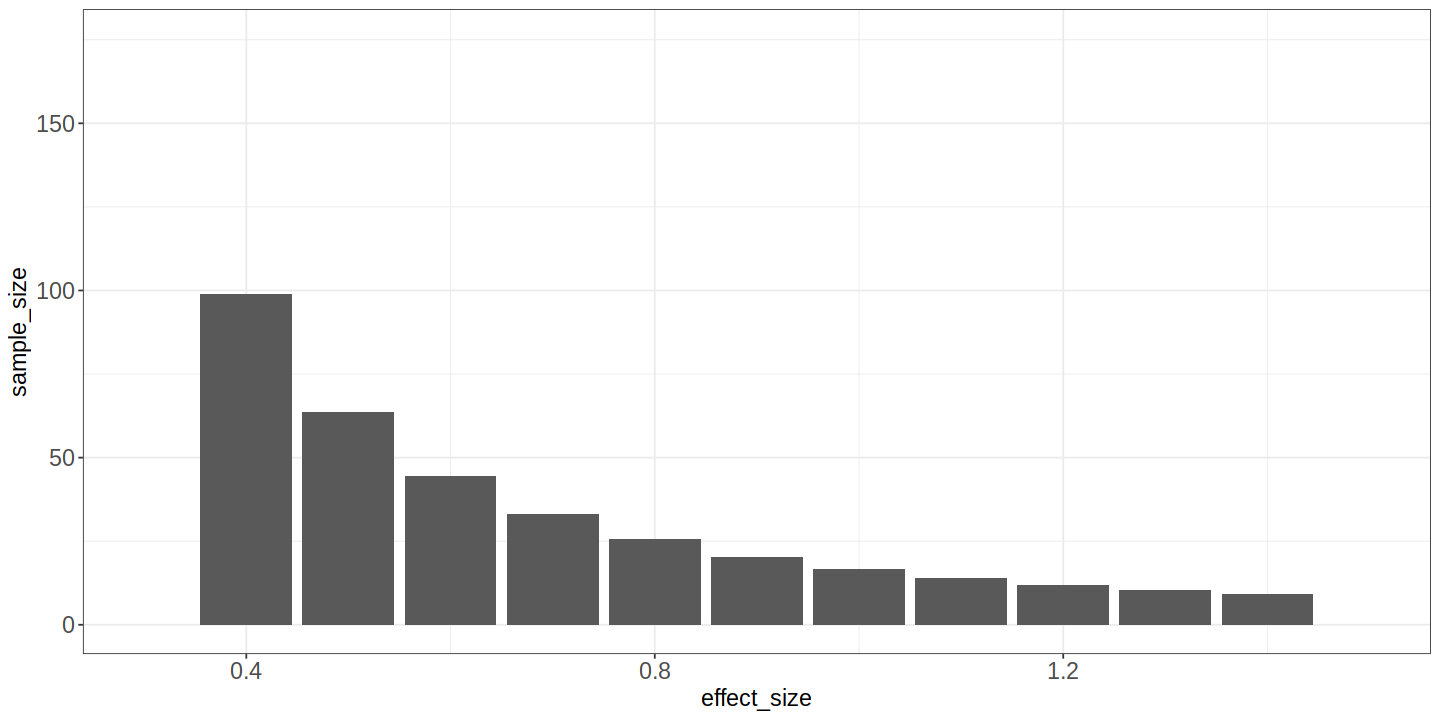

In [237]:
ggplot(result_table,aes(x=effect_size,y=sample_size))+geom_bar(stat="identity")+
theme_bw()+
xlim(0.3,1.5)+
theme(axis.title.x =  element_text(size=14),
     axis.title.y =  element_text(size=14),
     axis.text.x = element_text(size=14),
     axis.text.y = element_text(size=14))

## Subsample all phyloseq

In [3]:
psAll.filt = readRDS("psAll_count.rds")

In [570]:
psAll.filt

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 785 samples ]
sample_data() Sample Data:       [ 785 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [14]:
getwd()

[1] "/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/shortbred"

In [22]:
write.csv(psAll.filt@sam_data,"metadata.psAll.filt.tsv",quote=FALSE)

In [723]:
count(as_tibble(psAll.filt@sam_data),category)

category,n
<chr>,<int>
Animal,572
Environmental,133
Plants,80


## Import animals metadata + taxonomy

In [12]:
library(dplyr)

In [13]:
nick.verts = read_tsv("../host_phylogeny/unified_metadata_complete_200429.tsv")

ERROR: Error in read_tsv("../host_phylogeny/unified_metadata_complete_200429.tsv"): could not find function "read_tsv"


In [4]:
vert.metadata = read_tsv("../host_phylogeny/unified_metadata_all_vertebrates.tsv",col_names=T)

ERROR: Error in read_tsv("../host_phylogeny/unified_metadata_all_vertebrates.tsv", : could not find function "read_tsv"


In [1107]:
names(vert.metadata)

[1] "Sample"           "body_habitat"     "body_product"     "country"         
 [5] "diet"             "geo_loc_name"     "host_common_name" "host_subject_id" 
 [9] "host_taxid"       "latitude"         "longitude"

In [788]:
library(taxonomizr)

In [1109]:
assignTaxonomy = function(metadata.table){
    accesionTaxa.db = "/ebio/abt3_projects2/databases_no-backup/NCBI_accession2taxid/accessionTaxa.sql"
    taxonomyTable = metadata.table %>%
                    mutate(ncbi_taxid=metadata.table$host_taxid)%>%
                  mutate(ncbi_phylum=getTaxonomy(metadata.table$host_taxid,accesionTaxa.db,desiredTaxa=c("phylum")))%>%
                  mutate(ncbi_class=getTaxonomy(metadata.table$host_taxid,accesionTaxa.db,desiredTaxa=c("class")))%>%
                  mutate(ncbi_order=getTaxonomy(metadata.table$host_taxid,accesionTaxa.db,desiredTaxa=c("order")))%>%
                  mutate(ncbi_family=getTaxonomy(metadata.table$host_taxid,accesionTaxa.db,desiredTaxa=c("family")))%>%
                  mutate(ncbi_genus=getTaxonomy(metadata.table$host_taxid,accesionTaxa.db,desiredTaxa=c("genus")))%>%
                  mutate(ncbi_species=getTaxonomy(metadata.table$host_taxid,accesionTaxa.db,desiredTaxa=c("species")))
    
    return(taxonomyTable)
}

In [1110]:
VertTax = assignTaxonomy(vert.metadata)

In [1112]:
nrow(VertTax)

[1] 734

## Option 1: To the median within each category

### Subsample animals

In [571]:
ps.animals = ps_filter(psAll.filt,biome_2%in%c("Reptilia","Amphibia","Aves","Actinopterygii","Mammalia"))

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



In [931]:
ps.animals

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9335 taxa and 572 samples ]
sample_data() Sample Data:       [ 572 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9335 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9335 tips and 9321 internal nodes ]

In [722]:
count.animals = count(as_tibble(ps.animals@sam_data),biome_2)
count.animals

biome_2,n
<chr>,<int>
Actinopterygii,53
Amphibia,11
Aves,100
Mammalia,394
Reptilia,14


In [575]:
count.animals$biome_2

[1] "Actinopterygii" "Amphibia"       "Aves"           "Mammalia"      
[5] "Reptilia"

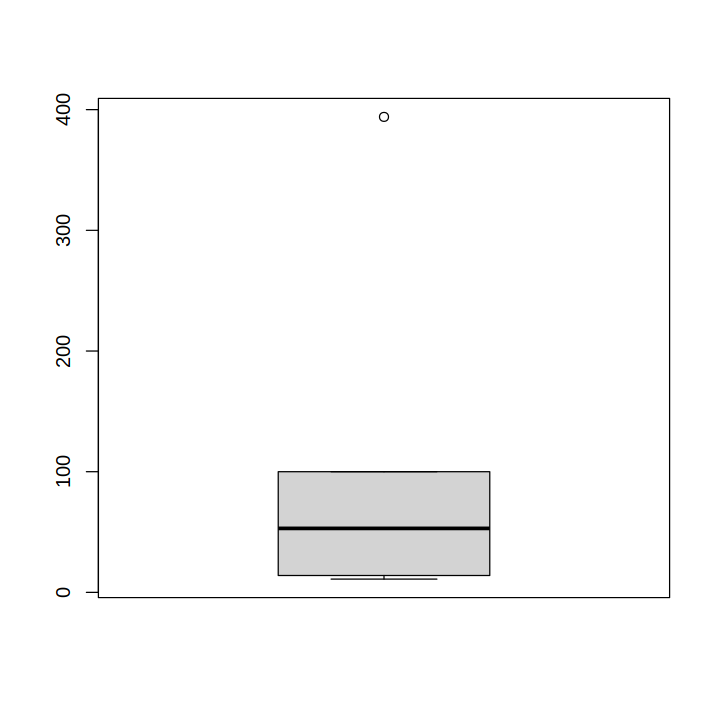

In [576]:
options(repr.plot.width=6,repr.plot.height=6)
boxplot(count.animals$n)

In [573]:
stats_animals = tibble(
    mean = mean(count.animals$n),
    median = median(count.animals$n),
    min = min(count.animals$n))

In [574]:
stats_animals

mean,median,min
<dbl>,<int>,<int>
114.4,53,11


In [577]:
#Subsample animals
minsamples_biome2 = median(table(sample_data(ps.animals)$biome_2))
samples_to_keep_biome2 <- c()
for (biome_2 in count.animals$biome_2) {
  biome_2 <- sample_names(ps.animals)[sample_data(ps.animals)$biome_2 == biome_2]
  if (length(biome_2) > minsamples_biome2) {
    biome_2 <- sample(biome_2, minsamples_biome2)
  }
  samples_to_keep_biome2 <- c(samples_to_keep_biome2, biome_2)
}

In [578]:
subsampled.animals = prune_samples(samples_to_keep_biome2,psAll.filt) #%>%
#merge_phyloseq(subsample_plants)

In [1115]:
subsampled.animals

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 184 samples ]
sample_data() Sample Data:       [ 184 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [1116]:
count(as_tibble(subsampled.animals@sam_data),biome_2)

biome_2,n
<chr>,<int>
Actinopterygii,53
Amphibia,11
Aves,53
Mammalia,53
Reptilia,14


#### Assign taxonomy

In [1125]:
subsampled.animals1.tax = inner_join(VertTax,as_tibble(subsampled.animals@sam_data),by="Sample")%>% 
select(contains("ncbi"))

In [1215]:
tmp1 = count(subsampled.animals1.tax,ncbi_class,ncbi_order)
tmp1[is.na(tmp1)] = "Reptiles"
tmp1$ncbi_class= str_replace_all(tmp1$ncbi_class,"Lepidosauria","Reptiles")
head(tmp1)

ncbi_class,ncbi_family,ncbi_order,n
<chr>,"<chr[,1]>","<chr[,1]>",<int>
Actinopteri,Cyprinidae,Cypriniformes,3
Actinopteri,Esocidae,Esociformes,2
Actinopteri,Leuciscidae,Cypriniformes,15
Actinopteri,Percidae,Perciformes,5
Actinopteri,Salmonidae,Salmoniformes,28
Amphibia,Bufonidae,Anura,3


In [1229]:
test.tmp1 = count(tmp1,ncbi_class)
test.tmp1

ncbi_class,n
<chr>,<int>
Actinopteri,5
Amphibia,3
Aves,21
Mammalia,20
Reptiles,9


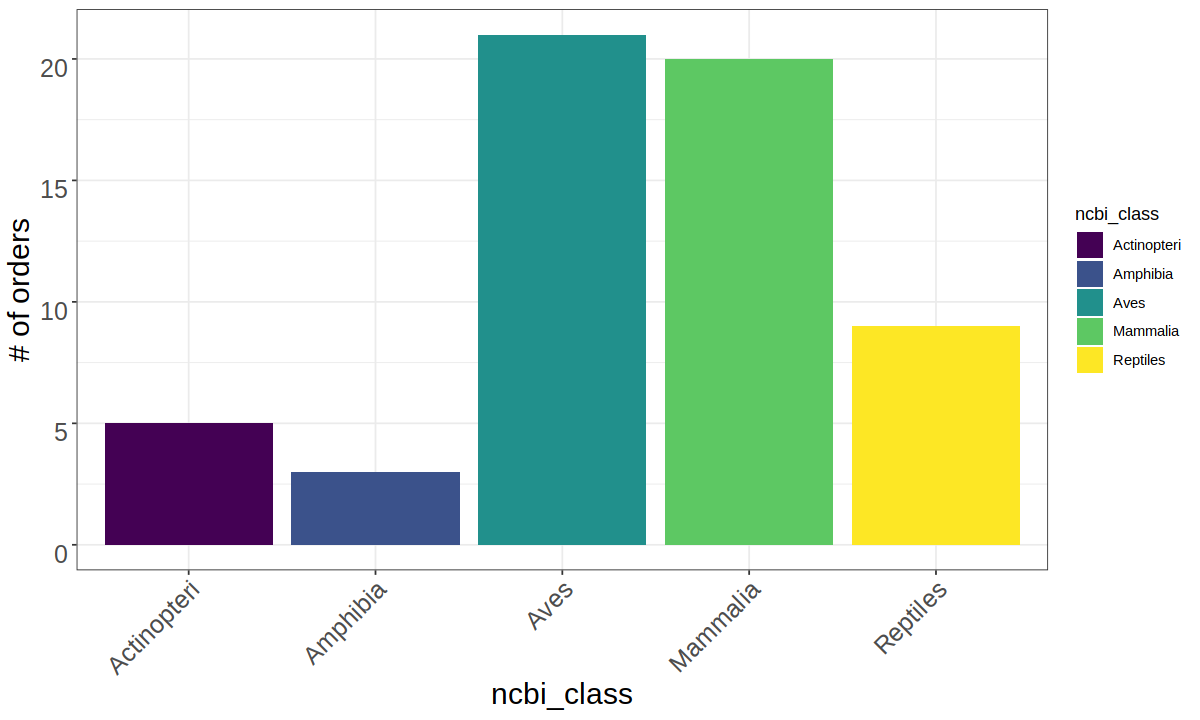

In [1232]:
options(repr.plot.widht=6,repr.plot.height=6)
ggplot(test.tmp1,aes(x=ncbi_class,y=n,fill=ncbi_class))+
theme_bw()+
geom_bar(stat="identity")+
 theme(axis.text.x = element_text(size=15,vjust=1,hjust=1,angle=45),
      axis.text.y = element_text(size=15,vjust=1,hjust=1),
      axis.title.x = element_text(size=18),
      axis.title.y = element_text(size=18))+
scale_fill_viridis_d()+
ylab("# of orders")

In [1126]:
head(subsampled.animals1.tax)

ncbi_taxid,ncbi_phylum,ncbi_class,ncbi_order,ncbi_family,ncbi_genus,ncbi_species
<dbl>,"<chr[,1]>","<chr[,1]>","<chr[,1]>","<chr[,1]>","<chr[,1]>","<chr[,1]>"
42408,Chordata,Mammalia,Rodentia,Cricetidae,Neotoma,Neotoma albigula
42408,Chordata,Mammalia,Rodentia,Cricetidae,Neotoma,Neotoma albigula
8022,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss
8022,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss
8022,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss
8022,Chordata,Actinopteri,Salmoniformes,Salmonidae,Oncorhynchus,Oncorhynchus mykiss


#### Create host dendrogram

In [1127]:
tmp.matrix = as.matrix(subsampled.animals1.tax[,2:ncol(subsampled.animals1.tax)])
treeSubsampled1 = makeNewick(tmp.matrix)

#### Export files

In [1129]:
write_file(treeSubsampled1,"treeSubsampled1.new")

In [926]:
write_lines(subsampled.animals1.tax$ncbi_taxid,"taxids_subsampledAnimals_method1.tsv")

In [1131]:
write_lines(unique(subsampled.animals1.tax$ncbi_species),"sppNames_subsampledAnimals_method1.tsv")

### Subsample environmental

In [579]:
ps.env = ps_filter(psAll.filt,biome_2%in%c("Aquatic","Terrestrial"))

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



In [580]:
count.env = count(as_tibble(ps.env@sam_data),biome_3)
count.env

biome_3,n
<chr>,<int>
Freshwater,28
Marine,63
Non-marine Saline and Alkaline,11
Soil,31


In [581]:
stats_env = tibble(
    mean = mean(count.env$n),
    median = median(count.env$n),
    min = min(count.env$n))

In [582]:
stats_env

mean,median,min
<dbl>,<dbl>,<int>
33.25,29.5,11


In [583]:
count.env$biome_3

[1] "Freshwater"                     "Marine"                        
[3] "Non-marine Saline and Alkaline" "Soil"

In [584]:
#Subsample environmental
phylo_object = ps.env
minsamples_biome3_env = 30#min(table(sample_data(ps_filter(psAll.filt,biome_2%in%c("Aquatic","Terrestrial")))$biome_2))
samples_to_keep_biome3_env <- c()
for (biome_3 in count.env$biome_3) {
  biome_3 <- sample_names(phylo_object)[sample_data(phylo_object)$biome_3 == biome_3]
  if (length(biome_3) > minsamples_biome3_env) {
    biome_3 <- sample(biome_3, minsamples_biome3_env)
  }
  samples_to_keep_biome3_env <- c(samples_to_keep_biome3_env, biome_3)
}

In [585]:
length(samples_to_keep_biome3_env)

[1] 99

In [586]:
subsampled.env = prune_samples(samples_to_keep_biome3_env,psAll.filt)

In [718]:
count(as_tibble(subsampled.env@sam_data),biome_3)

biome_3,n
<chr>,<int>
Freshwater,28
Marine,30
Non-marine Saline and Alkaline,11
Soil,30


### Subsample plants

In [587]:
ps.plants = ps_filter(psAll.filt,biome_2=="Plants")

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



In [771]:
count(as_tibble(ps.plants@sam_data),family)

family,n
<chr>,<int>
Asparagaceae,1
Asteraceae,2
Brassicaceae,24
Paniceae,6
Poaceae,3
Salviniaceae,42
NA,2


In [589]:
count.plants = count(as_tibble(ps.plants@sam_data),biome_3)
count.plants

biome_3,n
<chr>,<int>
Phyllosphere,45
Rhizosphere,35


In [590]:
stats_plants = tibble(
    mean = mean(count.plants$n),
    median = median(count.plants$n),
    min = min(count.plants$n))

In [591]:
stats_plants

mean,median,min
<dbl>,<dbl>,<int>
40,40,35


In [592]:
count.plants$biome_3

[1] "Phyllosphere" "Rhizosphere"

In [593]:
median(table(sample_data(ps.plants)$biome_3))

[1] 40

In [594]:
#Subsample plants
phylo_object = ps.plants
minsamples_biome3_plants = median(table(sample_data(ps.plants)$biome_3))

samples_to_keep_plants <- c()
for (biome_3 in count.plants$biome_3) {
  biome_3 <- sample_names(phylo_object)[sample_data(phylo_object)$biome_3 == biome_3]
  if (length(biome_3) > minsamples_biome3_plants) {
    biome_3 <- sample(biome_3, minsamples_biome3_plants)#length(samples_to_keep_biome2))
  }
  samples_to_keep_plants <- c(samples_to_keep_plants, biome_3)
}


In [595]:
subsampled.plants = prune_samples(samples_to_keep_plants,psAll.filt)

In [717]:
count(as_tibble(subsampled.plants@sam_data),biome_3)

biome_3,n
<chr>,<int>
Phyllosphere,40
Rhizosphere,35


### Concatenate all subsampled categories

In [596]:
subsampled.all = merge_phyloseq(subsampled.animals,
              subsampled.env,
              subsampled.plants)

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



In [597]:
subsampled.all

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 358 samples ]
sample_data() Sample Data:       [ 358 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [740]:
count(as_tibble(subsampled.all@sam_data),biome_2)

biome_2,n
<chr>,<int>
Actinopterygii,53
Amphibia,11
Aquatic,69
Aves,53
Mammalia,53
Plants,75
Reptilia,14
Terrestrial,30


## Option 2: Subsample to same samples/animal family

### Subsample animals - same # samples/family

In [761]:
count.family = count(as_tibble(ps.animals@sam_data),family)
count.family

family,n
<chr>,<int>
Acanthizidae,1
Accipitridae,5
Agamidae,1
Anatidae,25
Anguidae,1
Ardeidae,1
Atelidae,40
Balaenopteridae,1
Bovidae,35


In [762]:
nrow(count.family)

[1] 89

In [660]:
stats_animals_fam = tibble(
    mean = mean(count.family$n),
    median = median(count.family$n),
    min = min(count.family$n))

In [661]:
stats_animals_fam

mean,median,min
<dbl>,<int>,<int>
6.426966,2,1


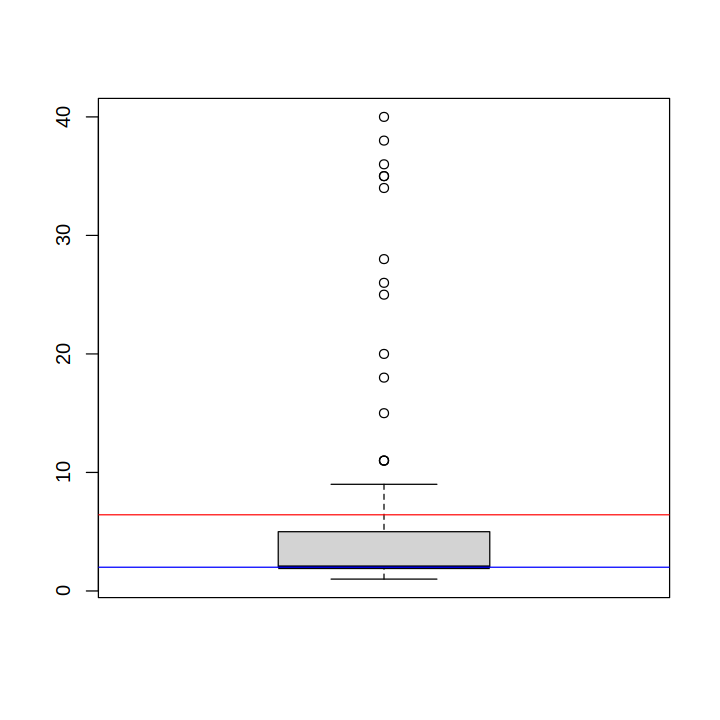

In [663]:
boxplot(count.family$n,breaks=20)
abline(h=mean(count.family$n),col="red")
abline(h=median(count.family$n),col="blue")

In [1175]:
#Subsample animals to the mean of samples/family
minsamples_family = round(median(table(sample_data(ps.animals)$family)))
samples_to_keep_family <- c()
for (family in count.family$family) {
  family <- sample_names(ps.animals)[sample_data(ps.animals)$family == family]
  if (length(family) > minsamples_family) {
    family <- sample(family, minsamples_family)
  }
  samples_to_keep_family <- c(samples_to_keep_family, family)
}

In [1176]:
subsampled.animals.fam = prune_samples(samples_to_keep_family,psAll.filt) #%>%
#merge_phyloseq(subsample_plants)

In [1177]:
subsampled.animals.fam

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [772]:
subsampled.animals.fam@sam_data

,Sample,Dataset,biome_0,biome_1,biome_2,biome_3,biome_4,family,category,mammals
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ERS1065341,ERS1065341,MGYS00000631,root,Host-associated,Mammalia,Digestive system,Stomach,Bovidae,Animal,Mammalia
ERS1579939,ERS1579939,MGYS00001583,root,Host-associated,Actinopterygii,Digestive system,Foregut,Salmonidae,Animal,Others
ERS1579947,ERS1579947,MGYS00001583,root,Host-associated,Actinopterygii,Digestive system,Foregut,Salmonidae,Animal,Others
ERS2085138,ERS2085138,MGYS00003488,root,Host-associated,Aves,Digestive system,Fecal,Phasianidae,Animal,Others
ERS2085187,ERS2085187,MGYS00003488,root,Host-associated,Aves,Digestive system,Fecal,Phasianidae,Animal,Others
ERS2867121,ERS2867121,MGYS00003472,root,Host-associated,Aves,Digestive system,Fecal,Anatidae,Animal,Others
ERS606451,ERS606451,MGYS00001193,root,Host-associated,Mammalia,Digestive system,Large intestine,Muridae,Animal,Mammalia
ERS723675,ERS723675,MGYS00001796,root,Host-associated,Mammalia,Digestive system,Large intestine,Felidae,Animal,Mammalia
ERS812545,ERS812545,MGYS00001951,root,Host-associated,Mammalia,Digestive system,Stomach,Bovidae,Animal,Mammalia


In [767]:
subsampled.all.2 = merge_phyloseq(subsampled.animals.fam,
              subsampled.env,
              subsampled.plants)

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



In [768]:
subsampled.all.2

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 332 samples ]
sample_data() Sample Data:       [ 332 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [769]:
count(as_tibble(subsampled.all.2@sam_data),category)

category,n
<chr>,<int>
Animal,158
Environmental,99
Plants,75


In [5]:
subsampled.all.2 = readRDS("subsampled_option2.rds")

In [8]:
count(as_tibble(subsampled.all.2@sam_data),biome_2)

Loading required package: phyloseq



biome_2,n
<chr>,<int>
Actinopterygii,8
Amphibia,6
Aquatic,69
Aves,42
Mammalia,88
Plants,75
Reptilia,14
Terrestrial,30


#### Assign taxonomy

In [1132]:
subsampled.animals2.tax = inner_join(as_tibble(subsampled.animals.fam@sam_data),as_tibble(VertTax)) %>% 
select(contains("ncbi"))

Joining, by = "Sample"


In [859]:
nrow(subsampled.animals2.tax)

[1] 147

In [1170]:
tmp = count(subsampled.animals2.tax,ncbi_class,ncbi_order)
tmp[is.na(tmp)] = "Reptiles"
tmp$ncbi_class= str_replace_all(tmp$ncbi_class,"Lepidosauria","Reptiles")
head(tmp)

ncbi_class,ncbi_order,n
<chr>,"<chr[,1]>",<int>
Actinopteri,Cypriniformes,2
Actinopteri,Esociformes,2
Actinopteri,Perciformes,2
Actinopteri,Salmoniformes,2
Amphibia,Anura,4
Amphibia,Caudata,2


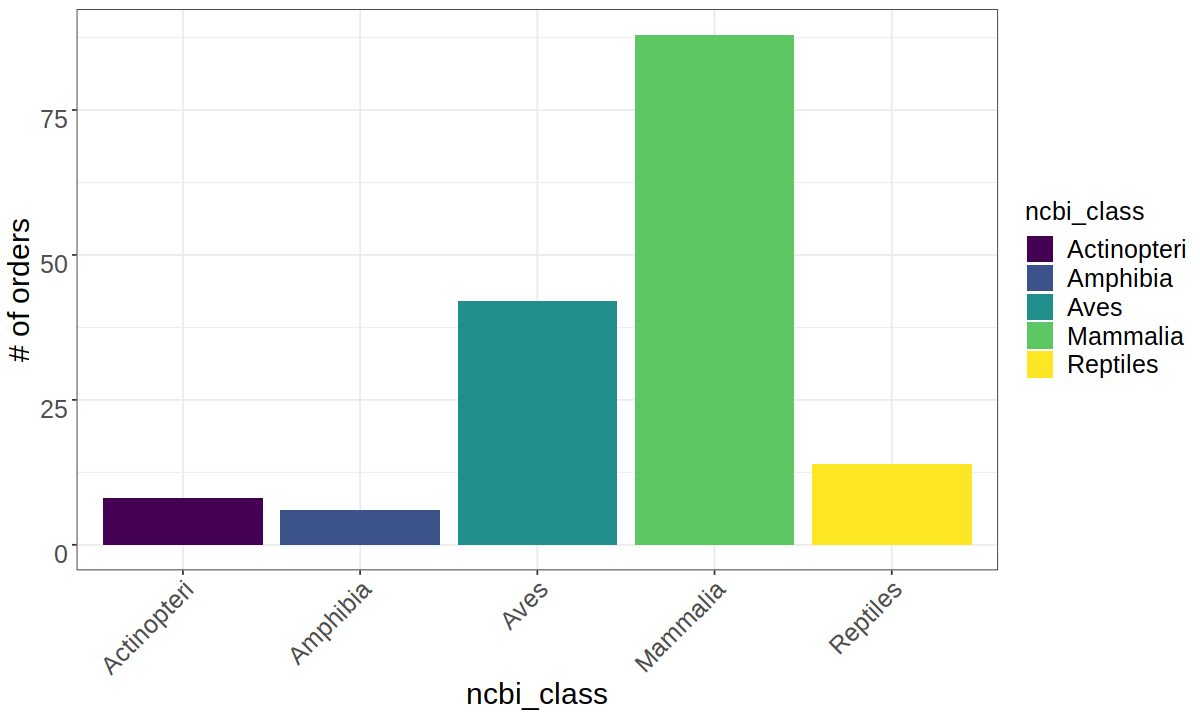

In [1235]:
options(repr.plot.widht=8,repr.plot.height=6)
ggplot(tmp,aes(x=ncbi_class,y=n,fill=ncbi_class))+
theme_bw()+
geom_bar(stat="identity")+
 theme(axis.text.x = element_text(size=15,vjust=1,hjust=1,angle=45),
      axis.text.y = element_text(size=15,vjust=1,hjust=1),
      axis.title.x = element_text(size=18),
      axis.title.y = element_text(size=18),
      legend.text = element_text(size=15),
      legend.title = element_text(size=15))+
scale_fill_viridis_d()+
ylab("# of orders")

#### Create host dendrogram

In [1133]:
tmp.matrix.2 = as.matrix(subsampled.animals2.tax[,2:ncol(subsampled.animals2.tax)])
treeSubsampled2 = makeNewick(tmp.matrix.2)

In [1134]:
treeSubsampled2

[1] "((((((Alces americanus)Alces,(Rusa unicolor)Rusa,(Cervus elaphus)Cervus)Cervidae,((Bos taurus)Bos)Bovidae,((Sus scrofa)Sus)Suidae,((Phocoena phocoena)Phocoena)Phocoenidae,((Balaenoptera borealis)Balaenoptera)Balaenopteridae,((Mesoplodon bidens)Mesoplodon)Ziphiidae,((Lagenorhynchus albirostris)Lagenorhynchus)Delphinidae,((Camelus ferus)Camelus)Camelidae,((Giraffa camelopardalis)Giraffa)Giraffidae,((Hippopotamus amphibius)Hippopotamus)Hippopotamidae)Artiodactyla,(((Mus musculus)Mus)Muridae,((Castor fiber)Castor)Castoridae,((Phodopus sungorus)Phodopus,(Myodes glareolus)Myodes)Cricetidae,((Marmota marmota)Marmota,(Spermophilus citellus)Spermophilus)Sciuridae,((Glis glis)Glis,(Eliomys quercinus)Eliomys)Gliridae,((Heteromys desmarestianus)Heteromys)Heteromyidae,((Proechimys semispinosus)Proechimys)Echimyidae)Rodentia,(((Felis catus)Felis,(Panthera leo)Panthera)Felidae,((Nyctereutes procyonoides)Nyctereutes,(Vulpes vulpes)Vulpes)Canidae,((Ursus arctos)Ursus)Ursidae,((Halichoerus grypus)Halichoerus,(Phoca vitulina)Phoca)Phocidae,((Potos flavus)Potos,(Procyon lotor)Procyon)Procyonidae,((Mustela eversmannii,Mustela putorius)Mustela)Mustelidae)Carnivora,(((Equus hemionus,Equus burchellii)Equus)Equidae,((Rhinoceros unicornis)Rhinoceros,(Ceratotherium simum)Ceratotherium)Rhinocerotidae)Perissodactyla,(((Erinaceus europaeus)Erinaceus)Erinaceidae,((Sorex alpinus)Sorex,(Crocidura suaveolens)Crocidura)Soricidae)Eulipotyphla,(((Nomascus gabriellae,Nomascus siki)Nomascus)Hylobatidae,((Nycticebus pygmaeus)Nycticebus)Lorisidae,((Otolemur crassicaudatus)Otolemur)Galagidae,((Alouatta caraya,Alouatta pigra)Alouatta)Atelidae,((Gorilla gorilla)Gorilla)Hominidae,((Papio anubis)Papio,(Piliocolobus badius)Piliocolobus)Cercopithecidae,((Lemur catta)Lemur)Lemuridae)Primates,(((Tupaia belangeri)Tupaia)Tupaiidae)Scandentia,(((Pipistrellus pipistrellus)Pipistrellus,(Eptesicus sagittula)Eptesicus)Vespertilionidae)Chiroptera,(((Macropus fuliginosus)Macropus,(Notamacropus eugenii)Notamacropus)Macropodidae,((Phascolarctos cinereus)Phascolarctos)Phascolarctidae,((Trichosurus vulpecula)Trichosurus)Phalangeridae)Diprotodontia,(((Tachyglossus aculeatus)Tachyglossus)Tachyglossidae)Monotremata,(((Smutsia temminckii)Smutsia)Manidae)Pholidota,(((Choloepus hoffmanni)Choloepus)Megalonychidae,((Tamandua mexicana)Tamandua)Myrmecophagidae,((Bradypus variegatus)Bradypus)Bradypodidae)Pilosa,(((Didelphis marsupialis)Didelphis,(Philander opossum)Philander)Didelphidae)Didelphimorphia,(((Loxodonta africana)Loxodonta)Elephantidae)Proboscidea,(((Lepus tolai,Lepus europaeus)Lepus)Leporidae)Lagomorpha)Mammalia,((((Oncorhynchus mykiss)Oncorhynchus)Salmonidae)Salmoniformes,(((Esox lucius)Esox)Esocidae)Esociformes,(((Leuciscus idus)Leuciscus,(Squalius cephalus)Squalius)Leuciscidae)Cypriniformes,(((Perca fluviatilis)Perca,(Gymnocephalus cernua)Gymnocephalus)Percidae)Perciformes)Actinopteri,((((Gallus gallus)Gallus)Phasianidae)Galliformes,(((Branta bernicla)Branta)Anatidae)Anseriformes,(((Tringa glareola)Tringa,(Scolopax rusticola)Scolopax)Scolopacidae)Charadriiformes,(((Phalacrocorax carbo)Phalacrocorax)Phalacrocoracidae,((Ardea cinerea)Ardea)Ardeidae)Pelecaniformes,(((Sylvia atricapilla)Sylvia,(Acrocephalus scirpaceus)Acrocephalus)Sylviidae,((Erithacus rubecula)Erithacus,(Turdus merula)Turdus)Turdidae,((Chloris chloris)Chloris)Fringillidae,((Parus major)Parus)Paridae,((Delichon urbicum)Delichon)Hirundinidae,((Corvus frugilegus)Corvus)Corvidae,((Acanthiza uropygialis)Acanthiza,(Hylacola cauta)Calamanthus)Acanthizidae,((Anthus spinoletta)Anthus)Motacillidae,((Prunella modularis)Prunella)Passeridae)Passeriformes,(((Falco tinnunculus)Falco)Falconidae)Falconiformes,(((Ciconia ciconia)Ciconia)Ciconiidae)Ciconiiformes,(((Strix aluco)Strix)Strigidae)Strigiformes,(((Haliaeetus albicilla)Haliaeetus,(Circus aeruginosus)Circus)Accipitridae)Accipitriformes,(((Dendrocopos major)Dendrocopos)Picidae)Piciformes,(((Dromaius novaehollandiae)Dromaius)Dromaiidae)Casuariiformes,(((Eolophus roseicapilla)Eol

#### Export files

In [1136]:
write_lines(subsampled.animals2.tax$ncbi_taxid,"taxids_subsampledAnimals_method2.tsv")

In [1139]:
write_file(treeSubsampled2,"treeSubsampled2.nwk")

In [1138]:
write_lines(unique(subsampled.animals2.tax$ncbi_species),"sppNames_subsampledAnimals_method2.tsv")

In [770]:
saveRDS(subsampled.all.2,"subsampled_option2.rds")

In [290]:
#Old subsampling method: subsampling depth=51 samples/biome_2
#saveRDS(subsampled,"nonrarepsAllfilt_subsampled.rds")

## Option 3: Subsample to the minimun # samples per biome_2

In [600]:
table(as_tibble(sample_data(psAll_count)$biome_2))

value
Actinopterygii       Amphibia        Aquatic           Aves       Mammalia 
            53             11            102            100            394 
        Plants       Reptilia    Terrestrial 
            87             14             31 

In [601]:
# subsample for the same number of samples across categories
stats_samples_biome2 <- tibble(
    min = min(table(sample_data(psAll_count)$biome_2)),# define number of samples to subsample
    mean = mean(table(sample_data(psAll_count)$biome_2)),
    median = median(table(sample_data(psAll_count)$biome_2)))
stats_samples_biome2

min,mean,median
<int>,<dbl>,<dbl>
11,99,70


In [602]:
# count the number of samples in each category
table(sample_data(psAll_count)$category)


       Animal Environmental        Plants 
          572           133            87 

In [603]:
# subsample for the same number of samples across categories
stats_samples_cat <- tibble(
    min = min(table(sample_data(psAll_count)$category)),# define number of samples to subsample
    mean = mean(table(sample_data(psAll_count)$category)),
    median = median(table(sample_data(psAll_count)$category)))
stats_samples_cat

min,mean,median
<int>,<dbl>,<int>
87,264,133


In [676]:
count.biome2 = count(as_tibble(psAll_count@sam_data),biome_2)
count.biome2

biome_2,n
<chr>,<int>
Actinopterygii,53
Amphibia,11
Aquatic,102
Aves,100
Mammalia,394
Plants,87
Reptilia,14
Terrestrial,31


In [604]:
phylo_object = psAll_count

In [731]:
#Subsample to the minimum sample size
minsamples_biome2 = min(table(sample_data(psAll.filt)$biome_2))
samples_to_keep_biome2 <- c()
for (biome_2 in count.biome2$biome_2) {
  biome_2 <- sample_names(phylo_object)[sample_data(phylo_object)$biome_2 == biome_2]
  if (length(biome_2) > minsamples_biome2) {
    biome_2 <- sample(biome_2, minsamples_biome2)
  }
  samples_to_keep_biome2 <- c(samples_to_keep_biome2, biome_2)
}

In [735]:
length(samples_to_keep_biome2)

[1] 88

In [736]:
subsampled.all.min = prune_samples(samples_to_keep_biome2,psAll.filt)

In [737]:
subsampled.all.min

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9963 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 9963 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9963 tips and 9945 internal nodes ]

In [739]:
count(as_tibble(subsampled.all.min@sam_data),biome_2)

biome_2,n
<chr>,<int>
Actinopterygii,11
Amphibia,11
Aquatic,11
Aves,11
Mammalia,11
Plants,10
Reptilia,11
Terrestrial,11


### Annotate taxonomy of subsampled animals

In [929]:
subsampled.animals3.tax = inner_join(as_tibble(subsampled.all.min@sam_data),as_tibble(taxonomy.verts)) %>% 
select(contains("ncbi"))

Joining, by = "Sample"


In [861]:
nrow(subsampled.animals3.tax)

[1] 41

In [1144]:
tmp3 = count(subsampled.animals3.tax,ncbi_class,ncbi_order)
head(tmp3)

ncbi_class,ncbi_order,n
"<chr[,1]>","<chr[,1]>",<int>
Actinopteri,Cypriniformes,3
Actinopteri,Perciformes,1
Actinopteri,Salmoniformes,1
Amphibia,Anura,7
Amphibia,Caudata,4
Aves,Accipitriformes,1


In [1168]:
tmp3[is.na(tmp3)] = "Reptiles"
#tmp3.1 = tmp3 %>%
tmp3$ncbi_class= str_replace_all(tmp3$ncbi_class,"Lepidosauria","Reptiles")
tmp3

ncbi_class,ncbi_order,n
<chr>,"<chr[,1]>",<int>
Actinopteri,Cypriniformes,3
Actinopteri,Perciformes,1
Actinopteri,Salmoniformes,1
Amphibia,Anura,7
Amphibia,Caudata,4
Aves,Accipitriformes,1
Aves,Anseriformes,1
Aves,Caprimulgiformes,1
Aves,Casuariiformes,1


In [1145]:
tmp.matrix.3 = as.matrix(subsampled.animals3.tax[,2:ncol(subsampled.animals3.tax)])
treeSubsampled3 = makeNewick(tmp.matrix.3)

In [919]:
treeSubsampled3

[1] "((((((Bufo bufo)Bufo,(Bufotes viridis)Bufotes)Bufonidae,((Rana temporaria,Rana dalmatina)Rana)Ranidae)Anura,(((Salamandra atra,Salamandra salamandra)Salamandra,(Lissotriton vulgaris)Lissotriton)Salamandridae)Caudata)Amphibia,((((Leuciscus aspius)Leuciscus,(Rutilus rutilus)Rutilus,(Chondrostoma nasus)Chondrostoma)Leuciscidae)Cypriniformes,(((Salmo trutta)Salmo)Salmonidae)Salmoniformes,(((Perca fluviatilis)Perca)Percidae)Perciformes)Actinopteri,((((Phodopus sungorus)Phodopus)Cricetidae)Rodentia,(((Tupaia belangeri)Tupaia)Tupaiidae)Scandentia,(((Otolemur crassicaudatus)Otolemur)Galagidae,((Alouatta caraya)Alouatta,(Lagothrix lagotricha)Lagothrix)Atelidae)Primates,(((Equus burchellii)Equus)Equidae)Perissodactyla)Mammalia,((((Haliaeetus albicilla)Haliaeetus)Accipitridae)Accipitriformes,(((Anser anser)Anser)Anatidae)Anseriformes,(((Corvus corone)Corvus)Corvidae)Passeriformes,(((Dendrocopos major)Dendrocopos)Picidae)Piciformes,(((Lyrurus tetrix)Lyrurus)Phasianidae)Galliformes,(((Dromaius novaehollandiae)Dromaius)Dromaiidae)Casuariiformes,(((Caprimulgus europaeus)Caprimulgus)Caprimulgidae)Caprimulgiformes)Aves,((((Hemidactylus frenatus)Hemidactylus)Gekkonidae,((Zamenis longissimus)Zamenis,(Natrix natrix)Natrix)Colubridae,((Podarcis siculus)Podarcis)Lacertidae,((Anguis fragilis)Anguis)Anguidae,((Varanus rosenbergi)Varanus)Varanidae,((Pogona vitticeps)Pogona)Agamidae,((Vipera ursinii)Vipera)Viperidae)Squamata)Lepidosauria,((((Testudo hermanni)Testudo)Testudinidae)Testudines,(((Crocodylus moreletii,Crocodylus niloticus)Crocodylus)Crocodylidae)Crocodylia)_)Chordata);"

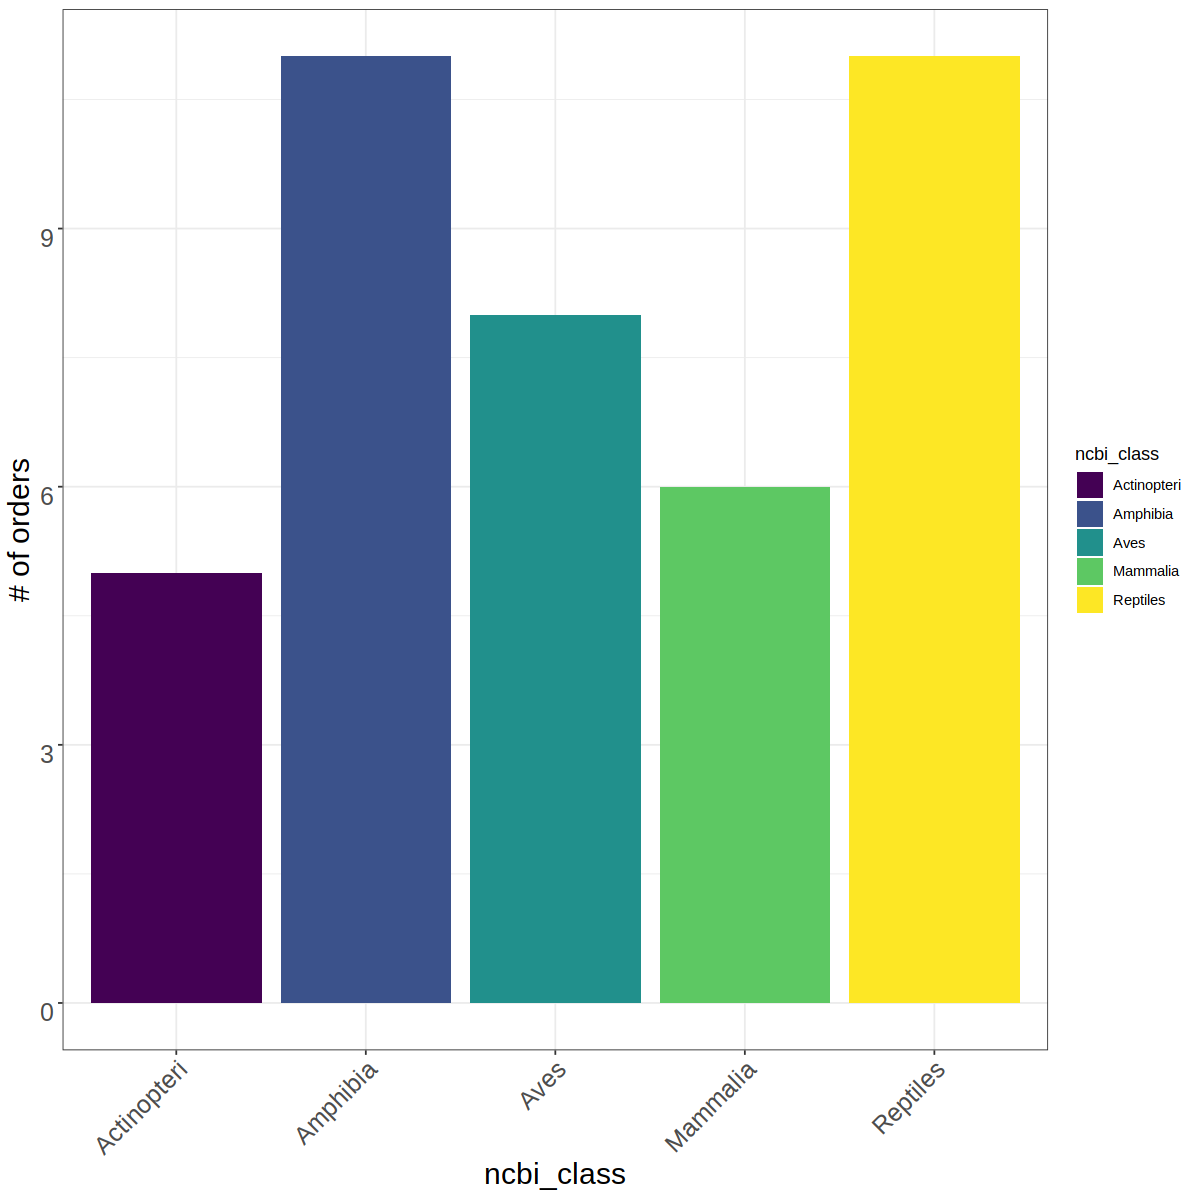

In [1191]:
options(repr.plot.widht=10,repr.plot.height=10)
ggplot(tmp3,aes(x=ncbi_class,y=n,fill=ncbi_class))+
theme_bw()+
geom_bar(stat="identity")+
 theme(axis.text.x = element_text(size=15,vjust=1,hjust=1,angle=45),
      axis.text.y = element_text(size=15,vjust=1,hjust=1),
      axis.title.x = element_text(size=18),
      axis.title.y = element_text(size=18))+
scale_fill_viridis_d()+
ylab("# of orders")

#### Export files

In [1140]:
write_lines(subsampled.animals3.tax$ncbi_taxid,"taxids_subsampledAnimals_method3.tsv")

In [1141]:
write_file(treeSubsampled3,"treeSubsampled3.nwk")

In [1142]:
write_lines(unique(subsampled.animals3.tax$ncbi_species),"sppNames_subsampledAnimals_method3.tsv")

In [701]:
saveRDS(subsampled.all.min,"subsampled.all.min.rds")

# OTU trees

### Option 1

In [755]:
tre.top.opt1=plot_tree(phyloseq_filter_top_taxa(subsampled.all,perc=1),color="category",label.tips="taxa_names")+
scale_color_npg()+
ggtitle("Option 1")

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



### Option 2

In [756]:
tre.top.opt2=plot_tree(phyloseq_filter_top_taxa(subsampled.all.2,perc=1),color="category",label.tips="taxa_names")+
scale_color_npg()+
ggtitle("Option 2")

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



### Option 3

In [757]:
tre.top.opt3=plot_tree(phyloseq_filter_top_taxa(subset.all.min,perc=1),color="category",label.tips="taxa_names")+
scale_color_npg()+
ggtitle("Option 3")

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Warning message in psmelt(physeq):
“The sample variables: 
Sample
 have been renamed to: 
sample_Sample
to avoid conflicts with special phyloseq plot attribute names.”
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'

Also defined by ‘RNeXML’



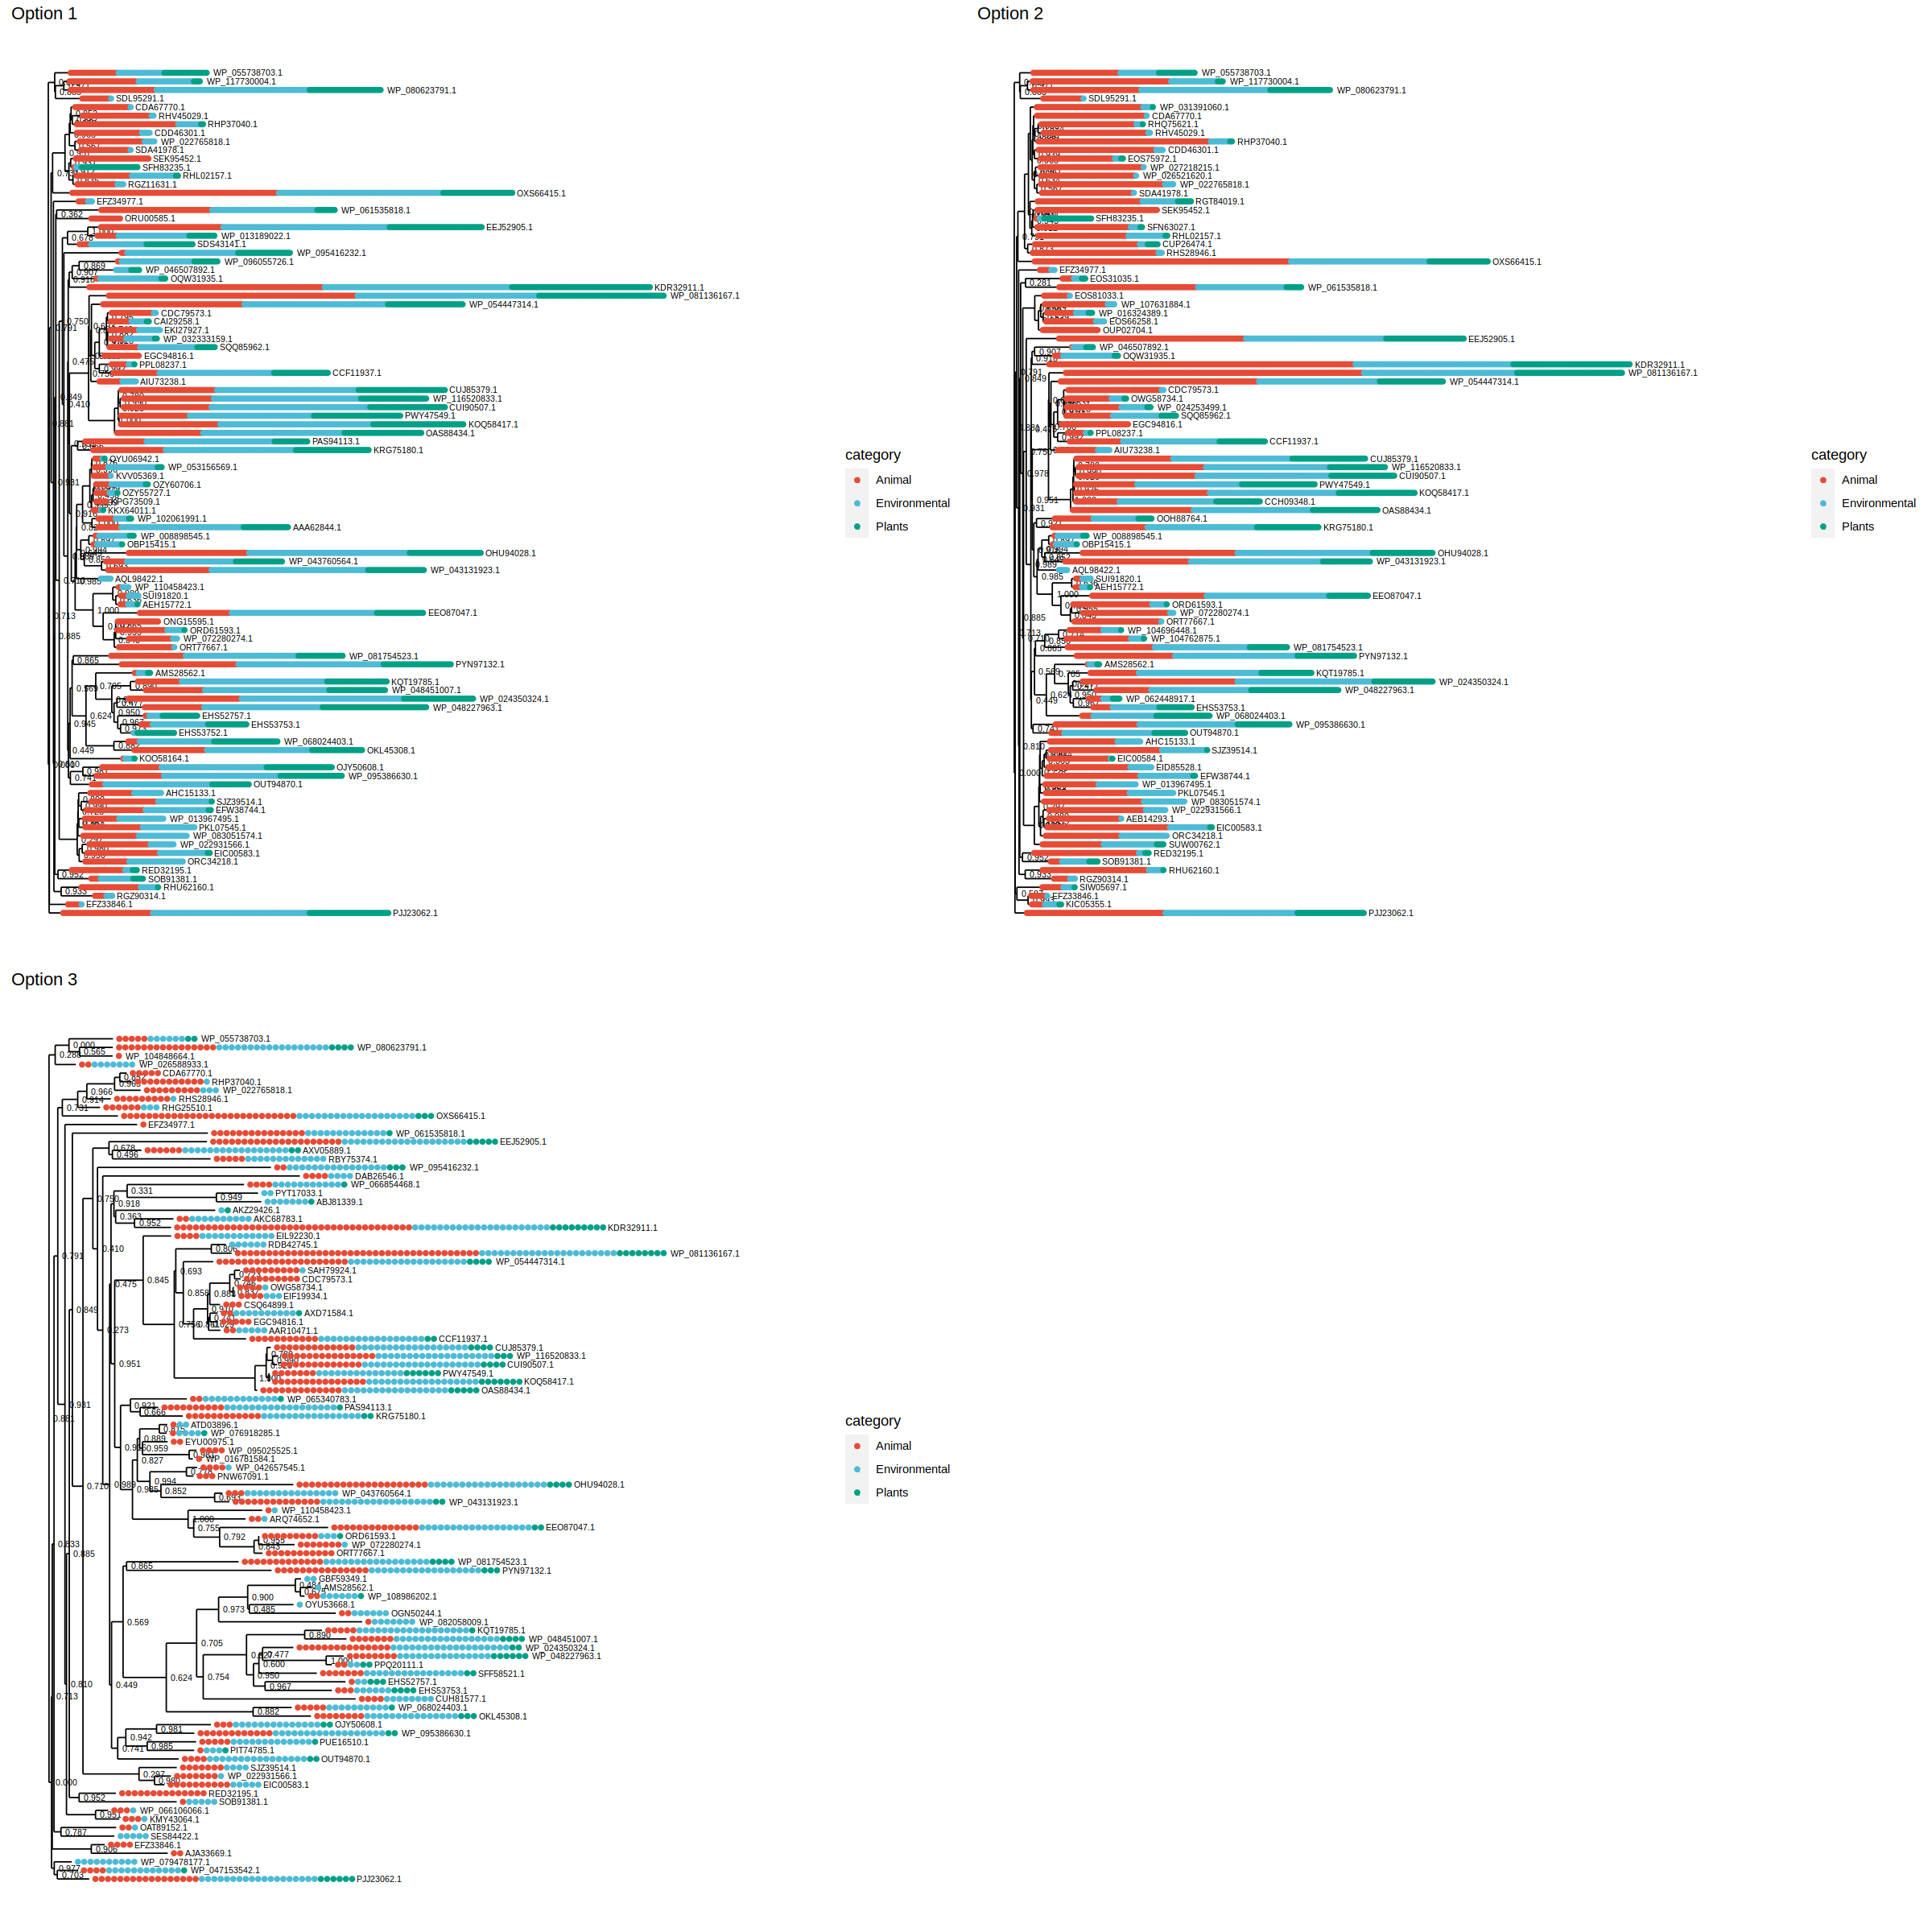

In [759]:
options(repr.plot.width=20,repr.plot.height=20)
grid.arrange(#tre.host.top.0.1,
             tre.top.opt1,
             tre.top.opt2,
             tre.top.opt3,
             nrow=2)